# Preparing Approximate GKP States using a GBS Device.

Term Paper MIT 6.S986 Silicon Photonics (Fall 2022). By Shoumik Chowdhury (@shoumikdc). 

In this notebook, we numerically simulate the preparation of finite-energy Gottesman-Kitaev-Preskill (GKP) states using an optical circuit of tunable beamsplitters and squeezers. We also introduce a decomposition of the tunable beamsplitter gate ${\rm BS}(\theta, \varphi)$ in terms of a Mach-Zehnder interferometer (MZI) --- i.e. balanced beamsplitters  ${\rm BS}(\pi/4, \pi/2)$ and phase shifters, and then simulate the robustness of GKP state preparation to fabrication imperfections in the beamsplitter transmissivity. 

For the actual GKP states, we use parameters from [Phys. Rev. A 101, 032315 (2020)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032315) and from [here](https://medium.com/xanaduai/riding-bosonic-qubits-towards-fault-tolerant-quantum-computation-95b92c78cb43) to prepare the approximate state $\left|0_\Delta\right> \approx S(0.196)[0.661\left|0\right> - 0.343\left|2\right> + 0.253\left|4\right>  - 0.368\left|6\right> + 0.377\left|8\right>  + 0.323\left|10\right>  + 0.365\left|12\right>]$. This state has 96.9% fidelity to the normalizable GKP state $\left|0_\Delta\right>$ for $\Delta = 10 \text{ dB}$. 

In [49]:
import numpy as np; π = np.pi
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

In [11]:
from bosonic import GKPQubit, plot_wigner

idealGKP = GKPQubit(params={"N":100, "delta": 0.3})
idealGKP.params["epsilon"]

0.3194725739184537

## 1. Ideal Preparation using Tunable Beamsplitters

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing and displacement to use. These parameters are taken directly from the references above.

In [12]:
m1, m2 = 5, 7
params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                   0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                   -0.24251599, 0.1958])
sq_r = params[:3]
bs_theta1, bs_theta2, bs_theta3 = params[3:6]
bs_phi1, bs_phi2, bs_phi3 = params[6:9]
sq_virt = params[9]

Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state.

In [145]:
nmodes = 3
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")

with prog.context as q:
    for k in range(3):
        Sgate(sq_r[k]) | q[k]
    
    """ Option 1 """
    Rgate(π + bs_phi1) | q[0]
    BSgate(π/4, π/2) | (q[0], q[1])
    Rgate(π - 2*bs_theta1) | q[0]
    BSgate(π/4, π/2) | (q[0], q[1])
    Rgate(-bs_phi1) | q[0]
    Rgate(bs_theta1) | q[0]
    Rgate(bs_theta1) | q[1]
    
    Rgate(π + bs_phi2) | q[1]
    BSgate(π/4, π/2) | (q[1], q[2])
    Rgate(π - 2*bs_theta2) | q[1]
    BSgate(π/4, π/2) | (q[1], q[2])
    Rgate(-bs_phi2) | q[1]
    Rgate(bs_theta2) | q[1]
    Rgate(bs_theta2) | q[2]

    Rgate(π + bs_phi3) | q[0]
    BSgate(π/4, π/2) | (q[0], q[1])
    Rgate(π - 2*bs_theta3) | q[0]
    BSgate(π/4, π/2) | (q[0], q[1])
    Rgate(-bs_phi3) | q[0]
    Rgate(bs_theta3) | q[0]
    Rgate(bs_theta3) | q[1]
    
    """ Option 2 """
#     BSgate(bs_theta1, bs_phi1) | (q[0], q[1])
#     BSgate(bs_theta2, bs_phi2) | (q[1], q[2])
#     BSgate(bs_theta3, bs_phi3) | (q[0], q[1])
    
    Sgate(sq_virt) | q[2]
    
state = eng.run(prog).state
mu, cov = state.means(), state.cov()

We can now inspect the covariance matrix and vector of means. Note that the vector of means is zero since we did not use any displacement gates in the circuit above.

In [147]:
print(np.round(mu, 10))
print(np.round(cov, 10))

[-0.  0.  0.  0.  0.  0.]
[[ 6.63867857  0.36942016 -3.62066097 -3.81871315  0.12296702 -0.30056321]
 [ 0.36942016  5.17112533 -3.72486422 -0.29251566  4.23941426 -0.19900173]
 [-3.62066097 -3.72486422  4.62142903  2.4078108  -2.5924352   0.841776  ]
 [-3.81871315 -0.29251566  2.4078108   3.74653358  1.74325906  2.95336303]
 [ 0.12296702  4.23941426 -2.5924352   1.74325906  6.23236943  3.60276109]
 [-0.30056321 -0.19900173  0.841776    2.95336303  3.60276109  5.54237845]]


We now use The Walrus to obtain the Fock representation of the Gaussian state emerging in the 3rd mode when modes 1 and 2 are heralded in the values $n_1=5$ and $n_2=7$. We also calculate the probability of success in heralding the state.

In [148]:
cutoff = 100
psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi / p_psi
print('The probability of successful heralding is {:.5f}.'.format(p_psi ** 2))

The probability of successful heralding is 0.00092.


We now plot the photon-number distribution of the heralded state. Note that the state has zero support on the odd Fock states due to its symmetry, and the support tapers off after $n=8$.

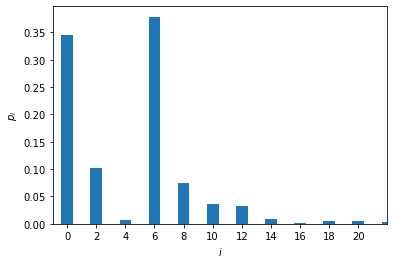

In [149]:
plt.bar(np.arange(cutoff), np.abs(psi) ** 2)
plt.xlim(-1, 22)
plt.xticks(np.arange(0, 22, 2))
plt.xlabel('$i$')
plt.ylabel(r'$p_i$')
plt.show()

We can now plot the Wigner function of the heralded state:

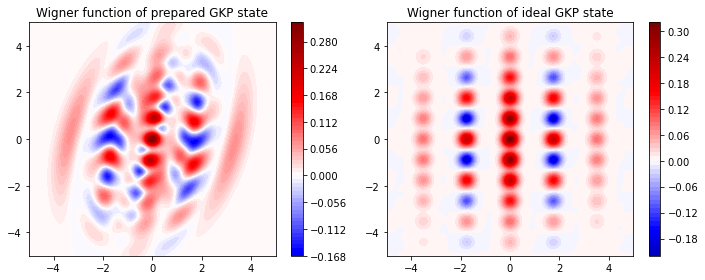

In [155]:
grid = 300
wigner_pts = np.linspace(-5,5, grid)

# plot_wigner(idealGKP.basis['+z'], wigner_pts, contour=False)
# ax = plt.gca()

W_prep = wigner(Qobj(psi), wigner_pts, wigner_pts)
W_ideal = wigner(idealGKP.basis['+z'], wigner_pts, wigner_pts)

wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt1 = axs[0].contourf(wigner_pts, wigner_pts, Wp, 60,  cmap=cm.seismic, norm=nrm)
axs[0].set_title("Wigner function of prepared GKP state");
cb1 = fig.colorbar(plt1, ax=axs[0])

plt2 = axs[1].contourf(wigner_pts, wigner_pts, W_ideal, 60,  cmap=cm.seismic, norm=nrm)
axs[1].set_title("Wigner function of ideal GKP state");
cb1 = fig.colorbar(plt2, ax=axs[1])


fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

In [151]:
np.abs(Qobj(psi).overlap(idealGKP.basis['+z']))**2

0.10270449899554036

## 2. Robustness to Beamsplitter Fabrication Imperfections
For this section, we investigate the effect of beamsplitter fabrication errors on the fidelity of GKP state preparation. To do so, we need to introduce a new decomposition for the tunable beamsplitter gate ${\rm BS}(\theta, \varphi)$, which is [defined](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.BSgate.html) in Strawberry Fields as:

\begin{equation}
    {\rm BS}(\theta, \varphi) = \begin{bmatrix}
        \cos(\theta) & -e^{-i\varphi}\sin(\theta) \\
        e^{i\varphi}\sin(\theta) & \cos(\theta)
    \end{bmatrix} 
\end{equation}

Observe that $B_{\rm bal} = {\rm BS}(\pi/4, \pi/2) = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & i \\ i & 1 \end{bmatrix}$ and that an imbalanced beamsplitter can be written ${\rm BS}(\theta) = {\rm BS}(\theta, \pi/2) = \frac{1}{\sqrt{2}}\begin{bmatrix} \cos(\theta) & i\sin(\theta) \\ i\sin(\theta) & \cos(\theta) \end{bmatrix}$.


The $2\times 2$ matrix above is the one that transforms the input mode operations $(\hat{a}_{\rm in}, \hat{b}_{\rm in})^T$ to outputs $(\hat{a}_{\rm out}, \hat{b}_{\rm out})^T$. In practice, we cannot directly implement ${\rm BS}(\theta, \varphi)$ using an integrated photonic circuit, but instead must built it up using 2 x 2 (i.e. 3 dB) couplers and phase shifters; that is, using a Mach-Zehnder interferometer (see also [here](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.MZgate.html)). Thus, we would like to decompose ${\rm BS}(\theta, \varphi)$ above into these primitives. 

Now, following [arXiv:2103.03183](https://arxiv.org/abs/2103.03183), we can build up arbitrary SU(2) operations using an MZI as follows:

\begin{equation}
    Z(\phi_i, \phi_e) = i e^{i \phi_i / 2}\begin{bmatrix}
        e^{i\phi_e}\sin(\phi_i/2) & \cos(\phi_i/2) \\
        e^{i\phi_e}\cos(\phi_i/2) & -\sin(\phi_i/2)
    \end{bmatrix} = \frac{1}{2}\begin{bmatrix}
        1 & i \\ i & 1
    \end{bmatrix}\!\begin{bmatrix}
        e^{i\phi_i} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        1 & i \\ i & 1
    \end{bmatrix}\!\begin{bmatrix}
        e^{i\phi_e} & 0 \\ 0 & 1
    \end{bmatrix}
\end{equation}

That is, $Z(\phi_i, \phi_e) = B_{\rm bal}R_1(\phi_i)B_{\rm bal}R_1(\phi_e)$. By redefining the phases, we find that

\begin{equation}
    Z(\pi-\phi_i, \pi+\phi_e) = e^{-i \phi_i / 2}\begin{bmatrix}
        e^{i\phi_e}\cos(\phi_i/2) & -\sin(\phi_i/2) \\
        e^{i\phi_e}\sin(\phi_i/2) & \cos(\phi_i/2)
    \end{bmatrix}
\end{equation}

We see that this structure above closely resembles the desired Gaussian operation ${\rm BS}(\theta, \varphi)$ above, though with some different phases. However, the form of $Z(\phi_i, \phi_e)$ above suggests that we can fix this by constructing a new operator

\begin{equation}
    \widetilde{Z}(\phi_i, \phi_e, \phi_a) = i e^{i \phi_i / 2}\begin{bmatrix}
        e^{i\phi_e}e^{i\phi_a}\sin(\phi_i/2) & e^{i\phi_a}\cos(\phi_i/2) \\
        e^{i\phi_e}\cos(\phi_i/2) & -\sin(\phi_i/2)
    \end{bmatrix} = \frac{1}{2}\begin{bmatrix}
        e^{i\phi_a} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        1 & i \\ i & 1
    \end{bmatrix}\!\begin{bmatrix}
        e^{i\phi_i} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        1 & i \\ i & 1
    \end{bmatrix}\!\begin{bmatrix}
        e^{i\phi_e} & 0 \\ 0 & 1
    \end{bmatrix}
\end{equation}

which consists of adding in another phase shift $R(\phi_a)$ on the first mode by an angle $\phi_a$. We then see that

\begin{equation}
    \widetilde{Z}(\pi-\phi_i, \pi+\phi_e, \phi_a) = e^{-i \phi_i / 2}\begin{bmatrix}
        e^{i\phi_e}e^{i\phi_a}\cos(\phi_i/2) & -e^{i\phi_a}\sin(\phi_i/2) \\
        e^{i\phi_e}\sin(\phi_i/2) & \cos(\phi_i/2)
    \end{bmatrix}
\end{equation}

In particular, we have

\begin{equation}
    \widetilde{Z}(\pi-2\theta, \pi+\varphi, -\varphi) = e^{-i \theta}\begin{bmatrix}
        \cos(\theta) & -e^{-i\varphi}\sin(\theta) \\
        e^{i\varphi}\sin(\theta) & \cos(\theta)
    \end{bmatrix} = e^{-i \theta} {\rm BS}(\theta, \varphi)
\end{equation}

which is the desired gate up to a global phase (which we can remove via phase shifts on both modes by an amount $\theta$ after applying the above gate).

In [160]:
def prep_GKP_vs_BS(T = 0.5)
    """
    We use tunable beamsplitters to 
    """
    
    m1, m2 = 5, 7 # Heralding photon numbers
    params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                       0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                       -0.24251599, 0.1958])
    sq_r = params[:3]
    params[3:9] = params[3:9]
    bs_theta1, bs_theta2, bs_theta3 = params[3:6]
    bs_phi1, bs_phi2, bs_phi3 = params[6:9]
    sq_virt = params[9]
        
    nmodes = 3
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")

    with prog.context as q:
        for k in range(3):
            Sgate(sq_r[k]) | q[k]

        """ 
        We use an alternative decomposition of the tunable
        BS gate below in terms of balanced beamsplitters +
        phase shifters. We then introduce fabrication error
        to the balanced beamsplitters. 
        """
            
        # Recall T = cos²(θ)
        θ_BS_fab = np.arccos(np.sqrt(T))

        Rgate(π + bs_phi1) | q[0]
        BSgate(θ_BS_fab, π/2) | (q[0], q[1])
        Rgate(π - 2*bs_theta1) | q[0]
        BSgate(θ_BS_fab, π/2) | (q[0], q[1])
        Rgate(-bs_phi1) | q[0]
        Rgate(bs_theta1) | q[0]
        Rgate(bs_theta1) | q[1]

        Rgate(π + bs_phi2) | q[1]
        BSgate(θ_BS_fab, π/2) | (q[1], q[2])
        Rgate(π - 2*bs_theta2) | q[1]
        BSgate(θ_BS_fab, π/2) | (q[1], q[2])
        Rgate(-bs_phi2) | q[1]
        Rgate(bs_theta2) | q[1]
        Rgate(bs_theta2) | q[2]

        Rgate(π + bs_phi3) | q[0]
        BSgate(θ_BS_fab, π/2) | (q[0], q[1])
        Rgate(π - 2*bs_theta3) | q[0]
        BSgate(θ_BS_fab, π/2) | (q[0], q[1])
        Rgate(-bs_phi3) | q[0]
        Rgate(bs_theta3) | q[0]
        Rgate(bs_theta3) | q[1]

        Sgate(sq_virt) | q[2]

    state = eng.run(prog).state
    mu, cov = state.means(), state.cov()
        
    cutoff = 100
    psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
    p_psi = np.linalg.norm(psi)
    psi = psi / p_psi
    
    return np.abs(Qobj(psi).overlap(idealGKP.basis['+z']))**2

In [169]:
T_range = np.linspace(0.45, 0.55, 51)
fids = [prep_GKP_vs_BS(T) for T in T_range]

Text(0, 0.5, 'GKP State Prep Fidelity')

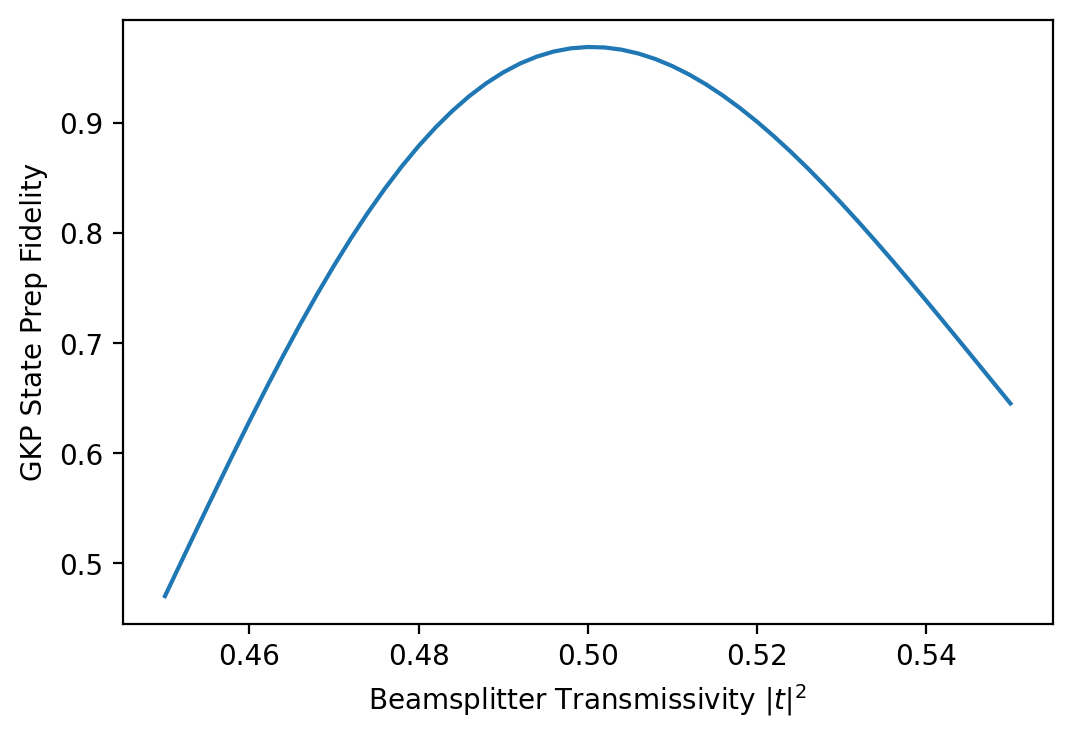

In [170]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_range, fids)
ax.set_xlabel(r"Beamsplitter Transmissivity $|t|^2$")
ax.set_ylabel(r"GKP State Prep Fidelity")

## 3. Totally Random Phases
Here, we try something silly and sample from a uniform distribution around $[1-\varepsilon, 1+\varepsilon]$ to randomly shift the tunable beamsplitter angles $\theta_i, \varphi_i$. We then perform batches of this sampling for various $\varepsilon$ to get a distribution. For each, we compute the fidelity of the prepared GKP state and then plot a histogram.

In [171]:
def random_GKP(ε):
    """
    For a given error ε multiplying the BS angles for the GKP circuit, 
    """
    
    m1, m2 = 5, 7 # Heralding photon numbers
    params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                       0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                       -0.24251599, 0.1958])
    sq_r = params[:3]
    params[3:9] = params[3:9] * np.random.uniform(1 - ε, 1 + ε, 6)
    bs_theta1, bs_theta2, bs_theta3 = params[3:6]
    bs_phi1, bs_phi2, bs_phi3 = params[6:9]
    sq_virt = params[9]
        
    nmodes = 3
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")

    with prog.context as q:
        for k in range(3):
            Sgate(sq_r[k]) | q[k]

        BSgate(bs_theta1, bs_phi1) | (q[0], q[1])
        BSgate(bs_theta2, bs_phi2) | (q[1], q[2])
        BSgate(bs_theta3, bs_phi3) | (q[0], q[1])

        Sgate(sq_virt) | q[2]

    state = eng.run(prog).state
    mu, cov = state.means(), state.cov()
        
    cutoff = 100
    psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
    p_psi = np.linalg.norm(psi)
    psi = psi / p_psi
    
    return np.abs(Qobj(psi).overlap(idealGKP.basis['+z']))**2

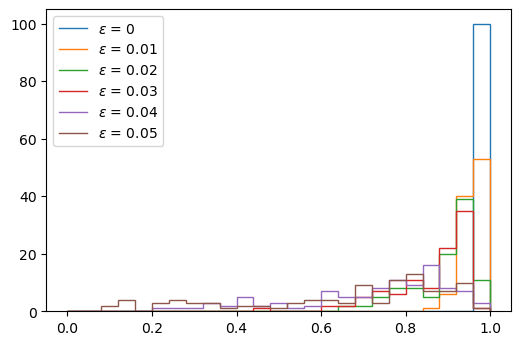

In [173]:
plt.figure(dpi=100)
for ε in [0, 0.01, 0.02, 0.03, 0.04, 0.05]:
    fids = [random_GKP(ε) for i in range(100)]
    hist = np.histogram(fids, bins=25, range=(0, 1))
    plt.stairs(hist[0], hist[1], label=fr"$\varepsilon$ = {ε}")
    
plt.legend(loc="upper left")